In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-03-01 00:00:00"),
                     end=string2ts("2017-06-01 0:00:00"),
                     period=3600*4)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-03-01 03:00:00,0.000005,4.63e-6,0.000005,0.000005,15460726.302517,70.237849,4.54e-6
2017-03-01 07:00:00,0.000005,4.68e-6,0.000005,0.000005,28742966.811435,129.852882,4.51e-6
2017-03-01 11:00:00,0.000004,4.51e-6,0.000005,0.000004,18132136.819725,80.003006,4.41e-6
2017-03-01 15:00:00,0.000004,4.45e-6,0.000004,0.000004,24762143.100886,108.245518,4.37e-6
2017-03-01 19:00:00,0.000005,4.91e-6,0.000005,0.000004,82550427.832174,385.693740,4.67e-6


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 2827.59381898


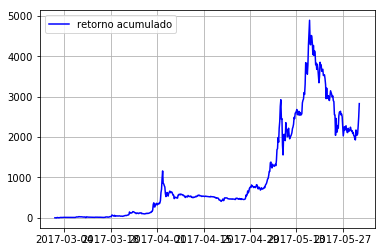

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

#plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno con la estrategia EMA_5 vs SMA_20 fue 1002.03468942


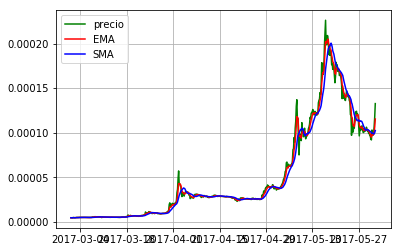

In [3]:
from profit import profit,change5, profit2
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    w['w'] = w['w'].shift(1)
    w["price"] = serie
    
    plt.plot(df.index[:],df['close'][:],'g',label='precio')
    plt.plot(df.index[:],ema[:],'r',label='EMA')
    plt.plot(df.index[:],sma[:],'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['close'])
relativeReturn, vecReturn = profit(w)

#relativeReturn2, vecReturn2 = profit2(w,1.0)

print 'El retorno con la estrategia EMA_5 vs SMA_20 fue %s'%(vecReturn[-1]*100)

w["return1"] = vecReturn
#print w.loc["2017-06-01 03:00:00":"2017-06-02 07:00:00",["orders","price","btc_balance","coin_balance","balance"]]
#print w[w["orders"]!="WAIT"][["orders","balance","btc_balance","coin_balance","price"]][:15]
#print w[["orders","w","return1","price"]][:15]

In [4]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5

w = pricevsEMA(df["close"])
relativeReturn,v = profit(w)

#Precio vs SMA_20

w2 = pricevsSMA(df["close"])
relativeReturn2,v2 = profit(w2)

print 'El retorno relativo con la estrategia precio VS SMA20 fue: %s'%(relativeReturn2*100)
print 'El retorno relativo con la estrategia Precio VS EMA20 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia precio VS SMA20 fue: 1286.10823261
El retorno relativo con la estrategia Precio VS EMA20 fue: 2697.93834694


Graficand los retornos de un par de estrategías y el comportamiento del precio

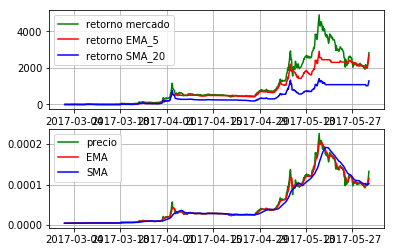

In [5]:
# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'r',label='retorno EMA_5')
plt.plot(df.index,v2*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()